# Sentiment Analysis Model - Word Frequencies

change current directory and import packages

In [1]:
%load_ext lab_black
import os
import numpy as np

In [2]:
if not os.path.exists("/sentiment_analysis"):
    os.chdir("..")

import packages

In [3]:
from sentiment_analysis.utils.train_test_split import TrainTestSplit
from sentiment_analysis.models.model import StreamlinedModel
from sentiment_analysis.features.word_frequencies import WordFrequencyVectorizer
from sentiment_analysis.features.tf_idf import TermFrequency_InvDocFrequency
from sentiment_analysis.data.review_processor import ReviewProcessor
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB, MultinomialNB
import matplotlib.pyplot as plt
import lightgbm as lgb
import shap
import pandas as pd

Perform train test split on the reviews data

In [4]:
X_train, y_train, X_test, y_test = TrainTestSplit().get_split_data()

### Logisitic Regression

In [5]:
logistic = StreamlinedModel(
    transformer_description="word frequency vector",
    transformer=WordFrequencyVectorizer,
    model_description="logisitc regression model",
    model=LogisticRegression,
)

train the streamlined model

In [6]:
logistic.train(X_train, y_train)

In [7]:
print("Train accuracy:", logistic.score(X_train, y_train))
print("Test accuracy:", logistic.score(X_test, y_test))

Train accuracy: 0.7673611111111112
Test accuracy: 0.745


get predictions

In [8]:
y_pred = logistic.predict(X_test)
y_prob_lg = logistic.predict_proba(X_test)

In [9]:
print("Test ROC:", roc_auc_score(y_test, y_prob_lg[:, 1]))

Test ROC: 0.8191312500000001


### Naive Bayes

In [10]:
gaussian_naive_bayes = StreamlinedModel(
    transformer_description="word frequency vector",
    transformer=WordFrequencyVectorizer,
    model_description="naive bayes model",
    model=GaussianNB,
)

In [11]:
gaussian_naive_bayes.train(X_train, y_train)

In [12]:
print("Train accuracy:", gaussian_naive_bayes.score(X_train, y_train))
print("Test accuracy:", gaussian_naive_bayes.score(X_test, y_test))

Train accuracy: 0.9361111111111111
Test accuracy: 0.62125


In [13]:
y_pred = gaussian_naive_bayes.predict(X_test)
y_prob_gnb = gaussian_naive_bayes.predict_proba(X_test)

In [14]:
print("Test ROC:", roc_auc_score(y_test, y_prob_gnb[:, 1]))

Test ROC: 0.61939375


In [15]:
multinomial_naive_bayes = StreamlinedModel(
    transformer_description="word frequency vector",
    transformer=WordFrequencyVectorizer,
    model_description="naive bayes model",
    model=MultinomialNB,
)

In [16]:
multinomial_naive_bayes.train(X_train, y_train)

In [17]:
print("Train accuracy:", multinomial_naive_bayes.score(X_train, y_train))
print("Test accuracy:", multinomial_naive_bayes.score(X_test, y_test))

Train accuracy: 0.8597222222222223
Test accuracy: 0.80625


In [18]:
y_pred = multinomial_naive_bayes.predict(X_test)
y_prob_mnb = multinomial_naive_bayes.predict_proba(X_test)

In [19]:
print("Test ROC:", roc_auc_score(y_test, y_prob_mnb[:, 1]))

Test ROC: 0.8830812499999999


### LightGBM

Build Word Frequency Vectors and lightGBM model and train using the training data

In [20]:
lightgbm = StreamlinedModel(
    transformer_description="word frequency vector",
    transformer=WordFrequencyVectorizer,
    model_description="LightGBM model",
    model=lgb.LGBMClassifier,
    model_params={
        "application": "binary",
        "objective": "binary",
        "metric": "auc",
        "is_unbalance": "false",
        "boosting": "gbdt",
        "num_leaves": 31,
        "feature_fraction": 0.06,
        "bagging_fraction": 0.67,
        "bagging_freq": 1,
        "learning_rate": 0.05,
        "verbose_eval": 0,
        "n_estimators": 2000,
        "n_jobs": 6,
    },
)

train the streamlined model

In [21]:
lightgbm.train(X_train, y_train)

get scores

In [22]:
print("Train accuracy:", lightgbm.score(X_train, y_train))
print("Test accuracy:", lightgbm.score(X_test, y_test))

Train accuracy: 0.9993055555555556
Test accuracy: 0.795


get predictions and predicted probabilities

In [23]:
y_pred = lightgbm.predict(X_test)
y_prob_lgbm = lightgbm.predict_proba(X_test)

In [24]:
print("Test ROC:", roc_auc_score(y_test, y_prob_lgbm[:, 1]))

Test ROC: 0.8847


We were able to achieve some quite amazing results with LightGBM model. The next two steps we can have a look are

1. Check the most wrong positive and negative reviews
2. use SHAP to understand which word are more likely to lead to lightGBM 

**Most wrong positive/negative reviews**

get the raw review texts and rank by smallest distance of 0/1

In [25]:
wrong_positive_inds = np.where((y_test == 1) & (y_pred != y_test))[0]
wrong_negative_inds = np.where((y_test == 0) & (y_pred != y_test))[0]

In [27]:
most_wrong_positive_index = wrong_positive_inds[
    y_prob_lgbm[:, 1][wrong_positive_inds].argmax()
]
most_wrong_negative_index = wrong_negative_inds[
    y_prob_lgbm[:, 1][wrong_negative_inds].argmin()
]

In [30]:
print("Most wrong positive review: \n")

print(np.array(X_test)[116])

Most wrong positive review: 

If you are just starting out on photography, I highly recommend this book. It begins immediately on the first chapter on picture making! For this reason alone, I would give it 5 stars. Here in the first chapter, the authors wasted no time to tell you what makes good pictures: the photographer, not the equipment. They then proceed to explain why the majority of our pictures (at least, the rest of us non-professionals) turn out unflattering despite our best efforts and high-tech cameras. If you read nothing else but the first chapter alone, I would bet that your photography will already begin to improve. Or if not, the first chapter will at least inspire you to try the suggestions and see the result yourself. In fact, even if all you have is a humble point and shoot film camera, the things they teach in the first chapter are still totally valid, as the principles of good photography remains the same whether you use film or digital.The next chapters give deta

In [31]:
print("Most wrong negative review: \n")

print(np.array(X_test)[most_wrong_negative_index])

Most wrong negative review: 

This book is so outdated. All the techniques listed in this book are from the 1980's and earlier, which means that most of the things you can learn from this book are already learned by you from the past. There are much more recent interesting researches and discoveries of human nature you can find in other books


As we can see, the most wrong positive/negative reviews would be pretty tough to get right even for human

**SHAP Model Explanation**

get shap explainer and training data

In [32]:
shap_explainer = shap.TreeExplainer(lightgbm.pipeline.steps[1][1])
training_data_transformed = lightgbm.pipeline.steps[0][1].transform(X_train)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


In [33]:
y_prob_train = lightgbm.predict_proba(X_train)

In [34]:
words_index_map = lightgbm.pipeline.steps[0][1].word_to_index_map
words_index_map = {k: v for k, v in sorted(words_index_map.items(), key=lambda x: x[1])}
column_names = list(words_index_map.keys())
training_data_transformed = pd.DataFrame(
    training_data_transformed, columns=column_names
)

get shap values

In [35]:
shap_values = shap_explainer.shap_values(training_data_transformed)

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


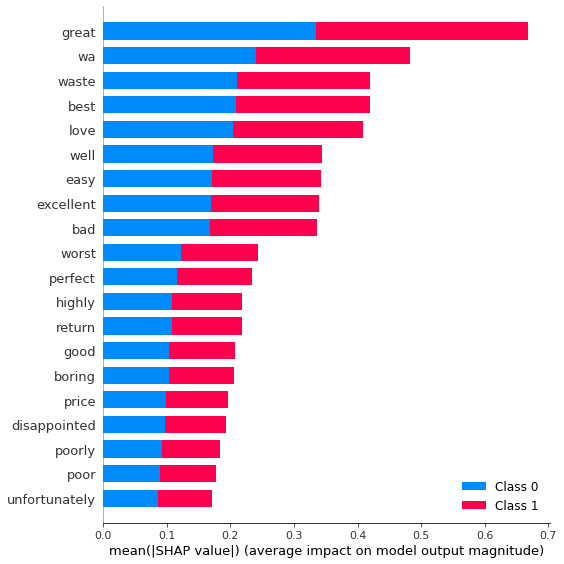

In [36]:
shap.summary_plot(shap_values, training_data_transformed)

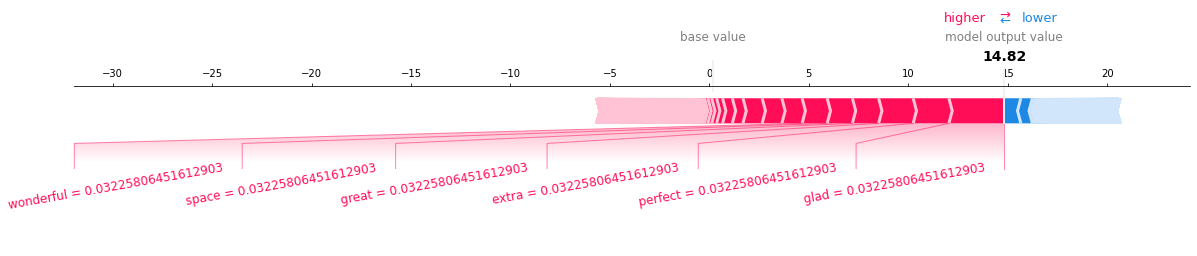

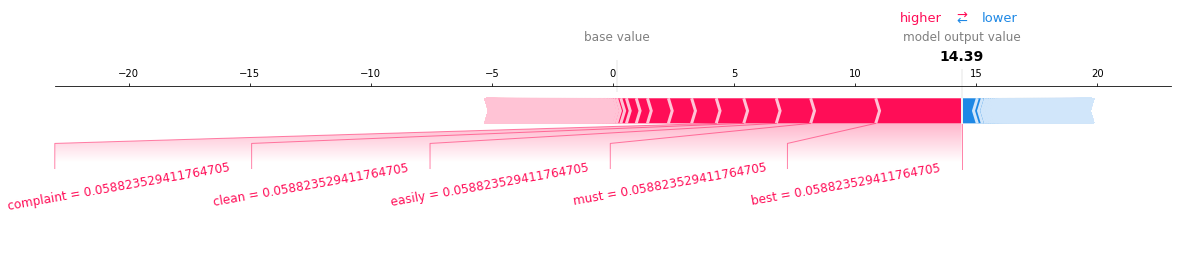

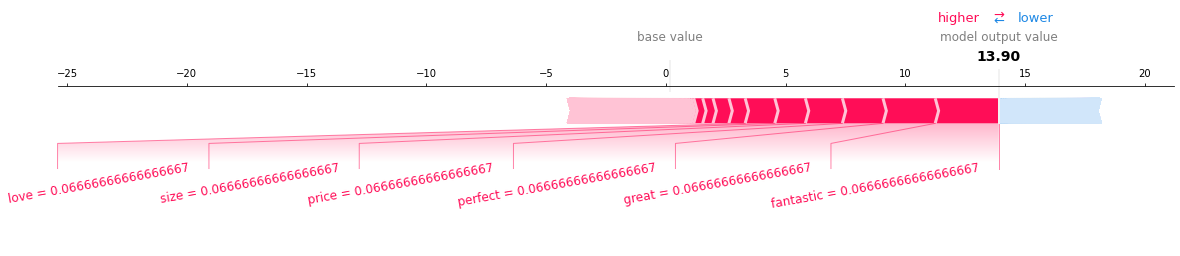

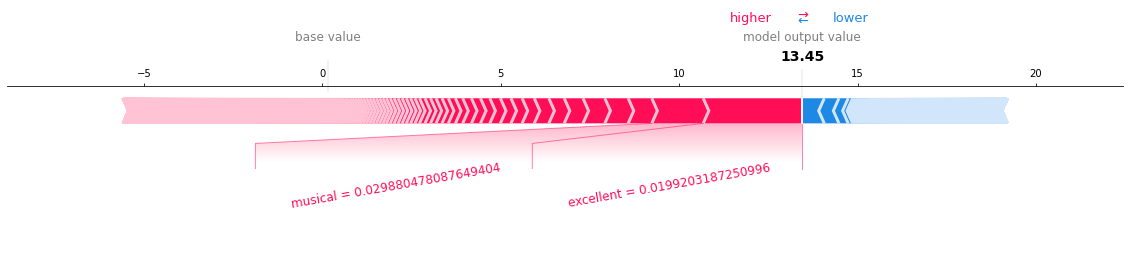

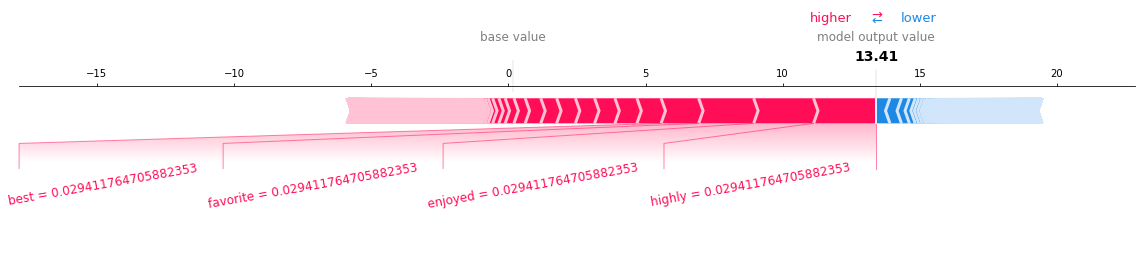

In [37]:
probs_low_to_high = sorted(
    range(len(y_prob_train[:, 1])), key=y_prob_train[:, 1].__getitem__
)
for i in range(5):
    shap.force_plot(
        shap_explainer.expected_value[0],
        shap_values[1][probs_low_to_high[-(i + 1)], :],
        training_data_transformed.iloc[probs_low_to_high[-(i + 1)], :],
        matplotlib=True,
        text_rotation=10,
    )

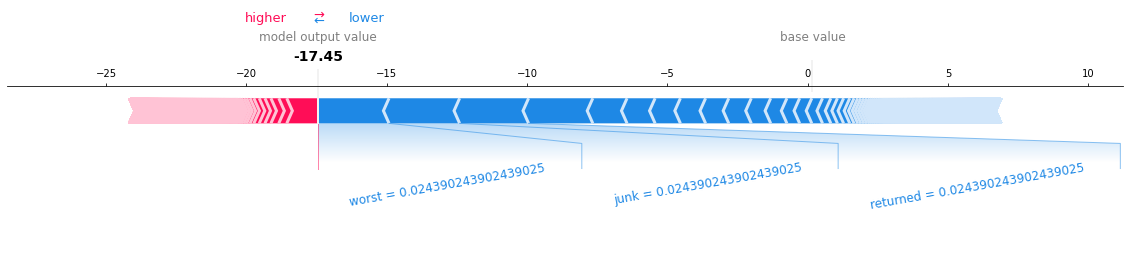

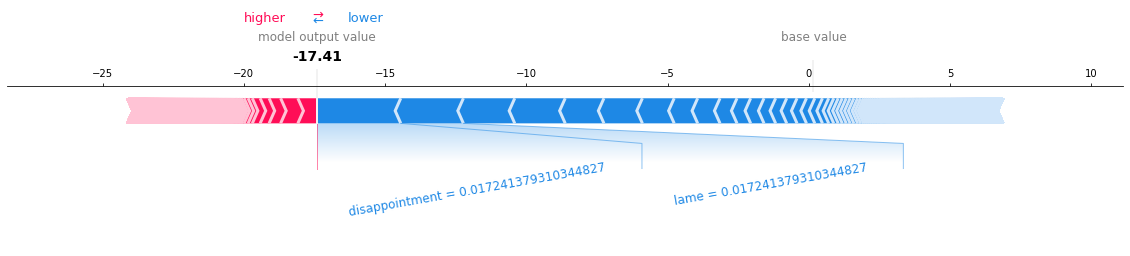

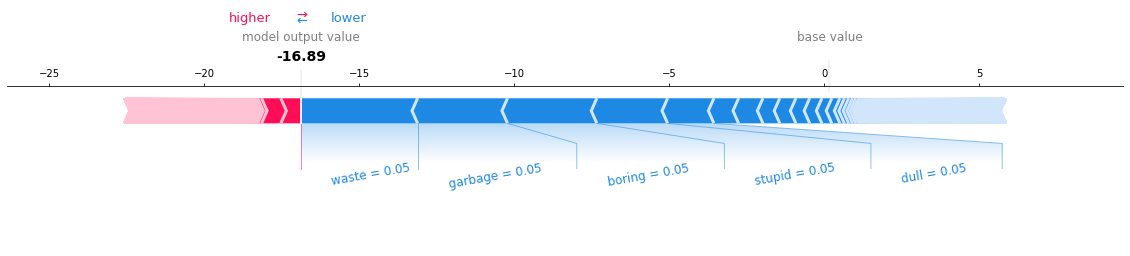

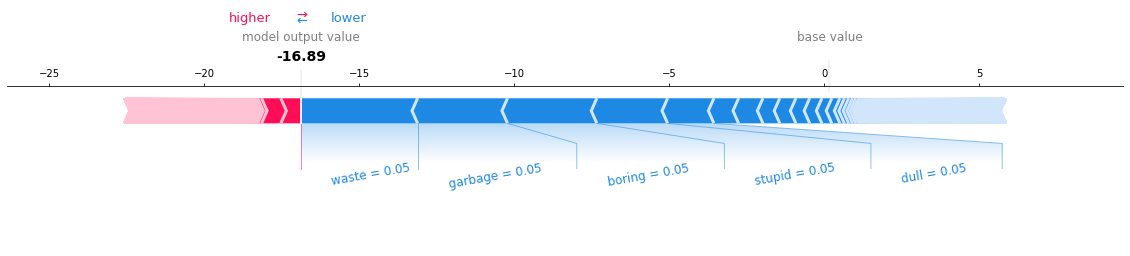

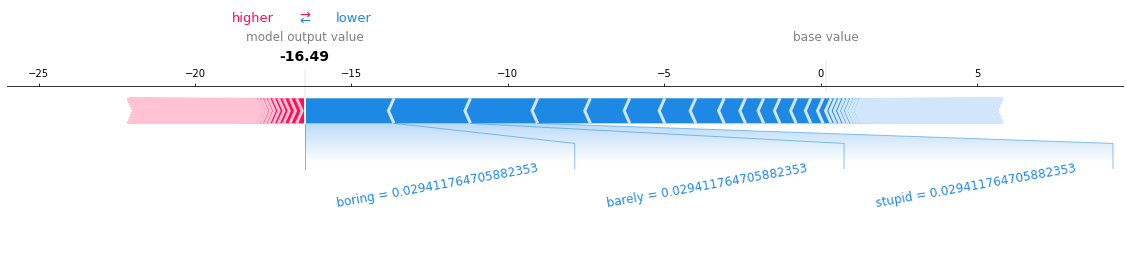

In [38]:
for i in range(5):
    shap.force_plot(
        shap_explainer.expected_value[0],
        shap_values[1][probs_low_to_high[i], :],
        training_data_transformed.iloc[probs_low_to_high[i], :],
        matplotlib=True,
        text_rotation=10,
    )

summary

In [39]:
aucs = pd.DataFrame(
    {
        "model": [
            "logistic regression",
            "gaussian naive bayes",
            "multinomial naive bayes",
            "lightgbm",
        ],
        "auc": [
            roc_auc_score(y_test, y_prob_lg[:, 1]),
            roc_auc_score(y_test, y_prob_gnb[:, 1]),
            roc_auc_score(y_test, y_prob_mnb[:, 1]),
            roc_auc_score(y_test, y_prob_lgbm[:, 1]),
        ],
    }
)

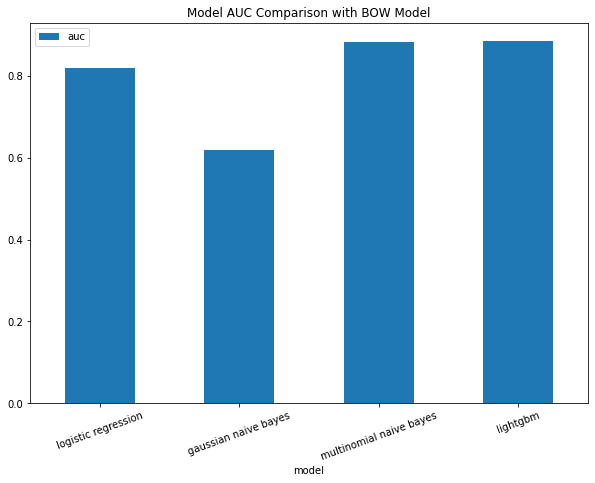

In [40]:
aucs.set_index("model").plot(
    kind="bar", figsize=(10, 7), title="Model AUC Comparison with BOW Model", rot=20
)

In [41]:
aucs

,model,auc
0,logistic regression,0.819131
1,gaussian naive bayes,0.619394
2,multinomial naive bayes,0.883081
3,lightgbm,0.884700
